In [1]:
import os
import sys
import numpy as np
import pandas as pd
import mudata as mu
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import sys
sys.path.append("/cellar/users/aklie/opt/gene_program_evaluation")
from src.evaluation.grn_models.filtering import filter_network

from src.evaluation.grn_models.scale_free_topology import _compute_scale_free_topology_fit
from src.evaluation.grn_models.tf_enrichment import _compute_tf_enrichment
from src.evaluation.grn_models.gene_expression_prediction import _compute_gene_expression_prediction, Ridge
from src.evaluation.association_categorical import compute_categorical_association
from src.evaluation.grn_models.network_structure import create_igraph_from_df, node_scores

from src.plotting.grn_models.plot_network_structure import plot_module, plot_grn_statistics
from src.plotting.grn_models.plot_goodness_of_fit import plot_scale_free_topology_fit, plot_goodness_of_fit
from src.plotting.grn_models.plot_tf_enrichment import plot_tf_activity_vs_expression, plot_tf_activity_on_dim_reduction

In [3]:
# Path to mudata
path_mdata = "/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/scenic/2024_05_20/scenic.h5mu"

# Load data

In [4]:
# MuData
mdata = mu.read_h5mu(path_mdata)
mdata

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 1047 × 155437
  obs:	'cell_line'
  var:	'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
  uns:	'grn'
  2 modalities
    rna:	1047 x 18666
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'annotation'
      var:	'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
      obsm:	'X_pca', 'X_umap'
      layers:	'counts', 'log1p_norm', 'scaled'
    atac:	1047 x 136771
      obs:	'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks', 'leiden'
      var:	'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count', 'selected'
      obsm:	'X_spectral', 'X_umap'
      layers:	'counts'

In [5]:
# Grab networks
grn = mdata.uns["grn"]
r2g = mdata.uns["r2g"] if "r2g" in mdata.uns else None
tf2r = mdata.uns["tf2r"] if "tf2r" in mdata.uns else None

# TF2r analysis

In [6]:
# tf2r link parameters
tf2r_score = 10
tf2r_cluster_key = "cluster"
tf2r_cluster = "global"

In [7]:
filtered_tf2r = filter_network(
    tf2r,
    source="tf",
    target="cre",
    score=tf2r_score,
    pval=None,
    ntop=None,
    cluster_key=tf2r_cluster_key,
    cluster=tf2r_cluster,
    min_regulators=0,
    min_targets=0,
)

TypeError: object of type 'NoneType' has no len()

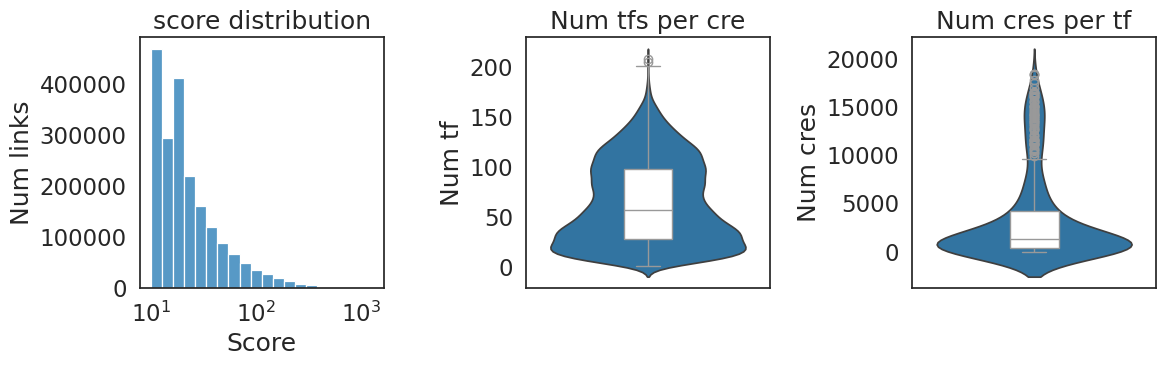

In [ ]:
plot_grn_statistics(
    filtered_tf2r,
    source_col="tf",
    target_col="cre",
    score_col="score",
)

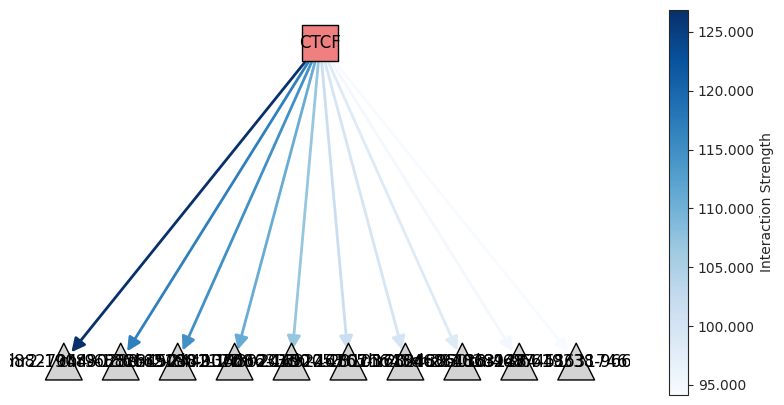

In [ ]:
plot_module(
    network_data=filtered_tf2r,
    source_name="CTCF",
    source_col="tf", 
    target_col="cre", 
    score_col="score", 
    n_top=10,
    source_color='lightcoral', 
    target_color='lightgrey', 
    source_shape='s', 
    target_shape='^'
)

# r2g analysis

In [ ]:
# r2g link parameters
r2g_score = 0.1
r2g_cluster_key = "cluster"
r2g_cluster = "global"

In [16]:
filtered_r2g = filter_network(
    r2g,
    source="cre",
    target="gene",
    score=r2g_score,
    pval=None,
    ntop=None,
    cluster_key=r2g_cluster_key,
    cluster=r2g_cluster,
    min_regulators=0,
    min_targets=0,
)

INFO:__main__:Initial network has 51761 edges
INFO:__main__:filtered_network for global has 51761 edges
INFO:__main__:filtered_network after filtering on edge strength has 51761 edges
INFO:__main__:filtered_network after filtering on top regulators has 51761 edges
INFO:__main__:filtered_network for global has 51761 edges
INFO:__main__:filtered_network after filtering on edge strength has 51761 edges
INFO:__main__:filtered_network after filtering on top regulators has 51761 edges
INFO:__main__:filtered_network after filtering on minimum number of targets has 51761 edges
INFO:__main__:filtered_network after filtering on minimum number of regulators has 51761 edges


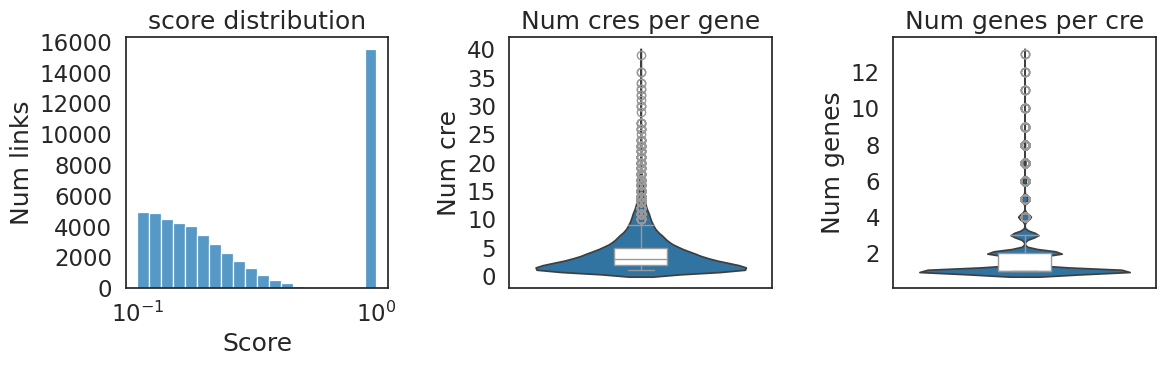

In [17]:
plot_grn_statistics(
    filtered_r2g,
    source_col="cre",
    target_col="gene",
    score_col="score",
)

# GRN analyses

## Filtering

In [8]:
# Filtering parameters
pval = None
score = 0
ntop = None
cluster_key = "cluster"
cluster = "global"
grn_key = "grn"
min_regulators = 0
min_targets = 0

In [9]:
# Filter
filtered_grn = filter_network(
    grn,
    source="tf",
    target="gene",
    pval=pval,
    score=score,
    ntop=ntop,
    cluster_key=cluster_key,
    cluster=cluster,
    min_regulators=min_regulators,
    min_targets=min_targets,
)

INFO:src.evaluation.grn_models.filtering:Initial network has 2562 edges
INFO:src.evaluation.grn_models.filtering:filtered_network for global has 2562 edges
INFO:src.evaluation.grn_models.filtering:filtered_network after filtering on edge strength has 2562 edges
INFO:src.evaluation.grn_models.filtering:filtered_network after filtering on top regulators has 2562 edges
INFO:src.evaluation.grn_models.filtering:filtered_network after filtering on minimum number of targets has 2562 edges
INFO:src.evaluation.grn_models.filtering:filtered_network after filtering on minimum number of regulators has 2562 edges
INFO:src.evaluation.grn_models.filtering:filtered_network for global has 2562 edges
INFO:src.evaluation.grn_models.filtering:filtered_network after filtering on edge strength has 2562 edges
INFO:src.evaluation.grn_models.filtering:filtered_network after filtering on top regulators has 2562 edges
INFO:src.evaluation.grn_models.filtering:filtered_network after filtering on minimum number of 

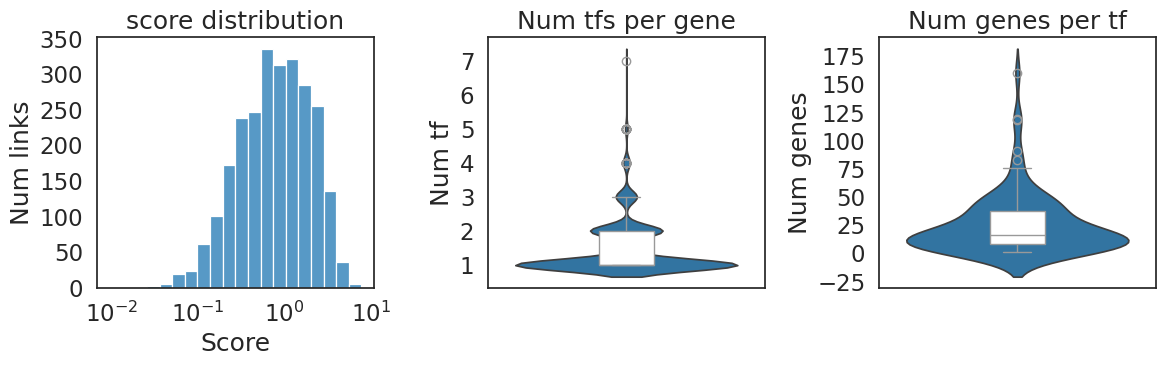

In [10]:
# Plot statistics
plot_grn_statistics(
    filtered_grn,
    source_col="tf",
    target_col="gene",
    score_col="score",
)

## Goodness of fit

In [11]:
# Goodness of fit parameters
layer = "log1p_norm"

(<Figure size 800x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'degree distribution'}, xlabel='k', ylabel='P(k)'>,
        <AxesSubplot: title={'center': 'degree distribution (log scale)\nslope: -1.164, r2: 0.6758'}, xlabel='log k', ylabel='log P(k)'>],
       dtype=object))

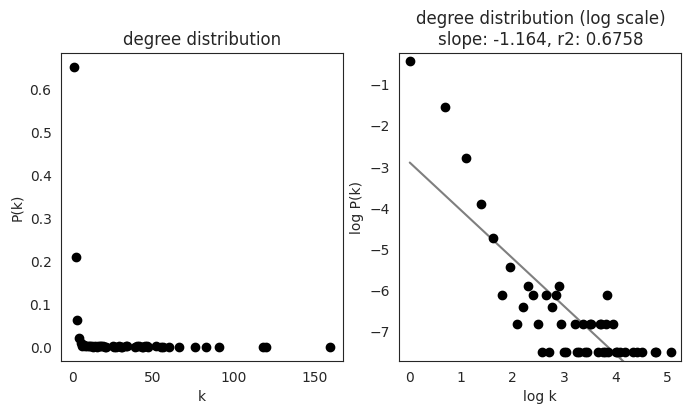

In [12]:
# Scale free topology
res = _compute_scale_free_topology_fit(filtered_grn, source="tf", target="gene")
plot_scale_free_topology_fit(res['degree_distribution'], res['model'])

In [13]:
# Ability to predict gene expression
fit_df =_compute_gene_expression_prediction(
    filtered_grn,
    mdata.mod["rna"],
    model=Ridge(alpha=10),
    min_regulators=3,
    source_key="tf",
    target_key="gene",
    layer=layer,
    verbose=False
)

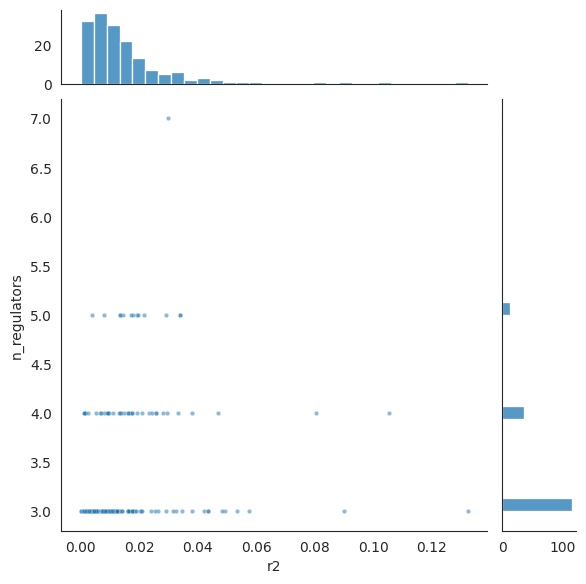

In [14]:
# Plot
plot_goodness_of_fit(fit_df)

## TF enrichment/activity

In [15]:
# TF enrichment parameters
method = "aucell"
layer = "log1p_norm"

In [16]:
import decoupler as dc

In [19]:
ENRICHMENT_METHODS = {
    "aucell": dc.run_aucell,
    "gsea": dc.run_gsea,
    "gsva": dc.run_gsva,
    "mdt": dc.run_mdt,
    "mlm": dc.run_mlm,
    "ora": dc.run_ora,
    "udt": dc.run_udt,
    "ulm": dc.run_ulm,
    "viper": dc.run_viper,
    "wmean": dc.run_wmean,
    "wsum": dc.run_wsum,
    "consensus": dc.run_consensus,
}


def _compute_tf_enrichment(
    grn: pd.DataFrame,
    adata: sc.AnnData,
    source: str = "tf",
    target: str = "gene",
    method: str = "aucell",
    score: str = "score",
    layer: str = None,
    min_n: int = 5,
    seed: int = 1234,
    kwargs: dict = {},
):
    adata_cp = adata.copy()
    if layer is not None:
        if layer not in adata_cp.layers:
            raise ValueError(f"Layer {layer} not found in adata.layers")
        adata_cp.X = adata_cp.layers[layer].copy()
    else:
        print("No layer provided, assuming we need to log normalize the matrix X")
        sc.pp.normalize_total(adata_cp, target_sum=1e4)
        sc.pp.log1p(adata_cp)
    
    # Check if method needs a "weight" argument
    method_fn = ENRICHMENT_METHODS[method]
    if "weight" in method_fn.__code__.co_varnames:
        kwargs["weight"] = score
    if "seed" in method_fn.__code__.co_varnames:
        kwargs["seed"] = seed
        
    # Run enrichment
    method_fn(
        mat=adata_cp,
        net=grn,
        source=source,
        target=target,
        min_n=min_n,
        use_raw=False,
        **kwargs
    )

    # Get activities
    acts = dc.get_acts(adata_cp, obsm_key=f'{method}_estimate')

    # Create adjacency matrix
    adj = grn.pivot_table(index=target, columns=source, values=score, fill_value=0)
    adj = adj[acts.var_names]
    adj = adj.reindex(adata.var_names, fill_value=0)
    acts.varm['loadings'] = adj.T.values

    return acts

In [20]:
# Compute
enrich = _compute_tf_enrichment(
    filtered_grn,
    adata=mdata.mod["rna"],
    source="tf",
    target="gene",
    method="consensus",
    score="score",
    layer="log1p_norm"
)

In [21]:
# Remove any all 0 features
enrich = enrich[:, enrich.X.sum(axis=0) > 0]
enrich

View of AnnData object with n_obs × n_vars = 1047 × 52
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'annotation'
    obsm: 'X_pca', 'X_umap', 'consensus_estimate', 'consensus_pvals'
    varm: 'loadings'

In [22]:
# Add to mdata
mdata.mod["tf_activity"] = enrich

## Covariate association

In [23]:
# Choose params
covariate_key = "annotation"
covariate = "H1"
dim_reduction_key = "X_pca"

In [24]:
# Run associations
association_df, posthoc_df = compute_categorical_association(
    mdata=mdata,
    prog_key="tf_activity",
    categorical_key=covariate_key,
    n_jobs=-1,
    inplace=False,
)
association_df["-log10_p_value"] = -np.log10(association_df[f"{covariate_key}_kruskall_wallis_pval"])
posthoc_df["-log10_p_value"] = -np.log10(posthoc_df["p_value"])

INFO:root:Performing tests at single-cell level. Significance will likely be inflated


Testing annotation association:   0%|          | 0/52 [00:00<?, ?programs/s]

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:1179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[k] = df_sub[k].cat.remove_unused_categories()


Identifying differential annotation:   0%|          | 0/52 [00:00<?, ?programs/s]

/tmp/ipykernel_2202474/61255715.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


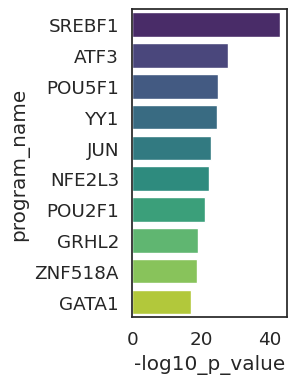

In [39]:
#seaborn barplot for the top 25 tfs
sns.set_style("white")
with sns.plotting_context("notebook", font_scale=1.2):
    plt.figure(figsize=(2, 4))
    sns.barplot(
        x="-log10_p_value",
        y="program_name",
        data=posthoc_df[posthoc_df[f"{covariate_key}_a"] == covariate].sort_values("-log10_p_value", ascending=False).head(10),
        palette="viridis",
    )

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/gene_program_evaluation/src/plotting/grn_models/plot_tf_enrichment.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha="right")
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette

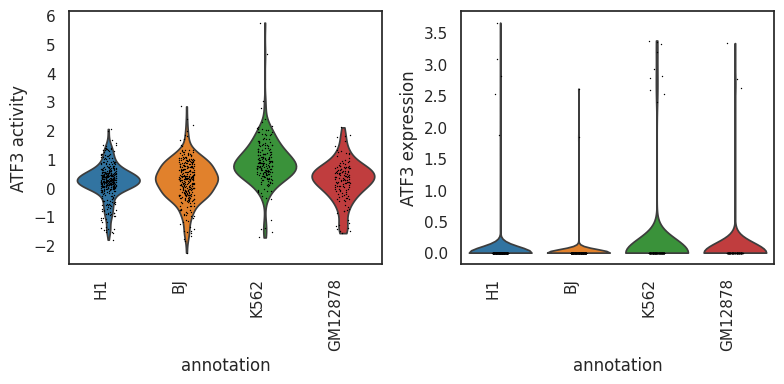

In [40]:
plot_tf_activity_vs_expression(
    enrich,
    mdata.mod["rna"],
    tf="ATF3",
    layer=layer,
)

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


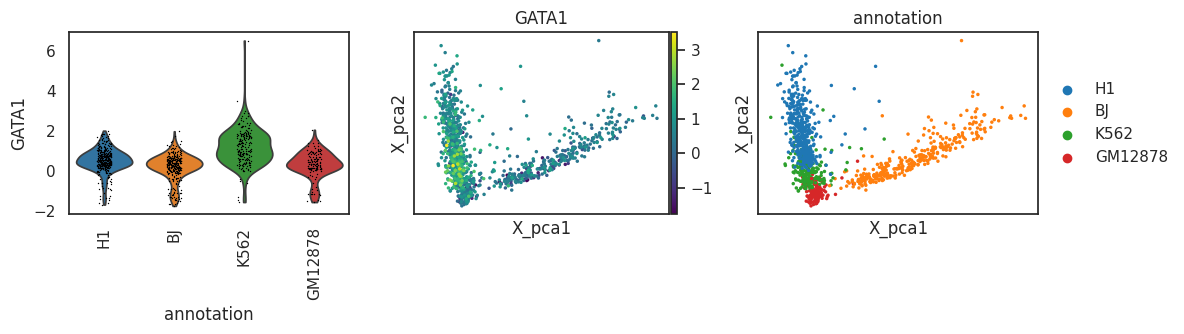

In [33]:
plot_tf_activity_on_dim_reduction(
    enrich,
    dim_reduction_key,
    tf="GATA1",
    cluster_key=covariate_key
)

## Network centrality

In [41]:
# Get node scores
grn_graph = create_igraph_from_df(grn, source_col="tf", target_col="gene", score_col="score", directed=True)
grn_node_scores = node_scores(grn_graph)
grn_node_scores

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,page_rank
AEBP2,20,0.010893,0,0.000000,20,0.010893,0.0,0.001269,0.000520
ASNS,3,0.001634,3,0.001634,0,0.000000,0.0,0.000873,0.000528
ATP5B,3,0.001634,3,0.001634,0,0.000000,0.0,0.000750,0.000549
CBX5,1,0.000545,1,0.000545,0,0.000000,0.0,0.000176,0.000571
CCDC186,1,0.000545,1,0.000545,0,0.000000,0.0,0.000103,0.000550
...,...,...,...,...,...,...,...,...,...
TOP2B,1,0.000545,1,0.000545,0,0.000000,0.0,0.000014,0.000592
ZNF91,8,0.004357,0,0.000000,8,0.004357,0.0,0.013887,0.000520
DENND1A,1,0.000545,1,0.000545,0,0.000000,0.0,0.001784,0.000579
SETD5,1,0.000545,1,0.000545,0,0.000000,0.0,0.000522,0.000537


# DONE!

---